In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import random
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras.optimizers.legacy import RMSprop
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Neural Network for Predicting Taxi Demand

In this notebook we train the Neural Network models. Similar to the SVM notebook, we first tune the network architecture and hyperparameters for the hexagon resolution 6 and time resolution 4 hours. Then we use the found hyperparameters to train models with other spatio-temporal resolutions and compare the results.

## Define Functions for Training Neural Network

In [2]:
def scale_data_and_get_dummies(data, location_bucket):
    # scale data except location bucket and demand
    col_scale_list = data.columns.to_list()
    col_scale_list.remove(location_bucket)
    col_scale_list.remove("demand")
    scaler = StandardScaler()
    data[col_scale_list] = scaler.fit_transform(data[col_scale_list])
    # create one hot encoding for location bucket feature
    data = pd.get_dummies(data, columns=[location_bucket], dtype=int)
    return data

def split_train_test(data, target_col="demand"):
    # split data into train and test
    X = data.drop(columns=[target_col])
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4711)
    return X_train, X_test, y_train, y_test 

We define a functions that builds the model architecture with different hidden layers, learning rate, dropout and activation function.

In [3]:
def build_model(X_train, layer_nodes = [64, 64], learning_rate=0.001, dropout=0, activation = 'relu', optimizer = RMSprop):
    model = models.Sequential()
    model.add(layers.Dense(layer_nodes[0], activation=activation, input_shape=(X_train.shape[1],)))
    if len(layer_nodes) > 1:
        for nodes in layer_nodes[1:]:
            model.add(layers.Dense(nodes, activation=activation))
            if dropout >= 0:
                model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='relu'))

    opt = optimizer(lr=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

Also, we define a k-fold function that does a k-fold cross validation based on given hyperparameters and returns evaluation metrics.

In [4]:
hyperparameters_default = {
    'layer_nodes': [64, 64],
    'learning_rate': 0.001,
    'dropout': 0,
    'activation': 'relu',
    'optimizer': RMSprop
}

def k_fold_nn(
        X_train, 
        y_train, 
        k=4, 
        epochs=50, 
        batch_size=1, 
        verbose=0,
        hyperparams=hyperparameters_default
        ):
    num_val_samples = len(X_train) // k
    num_epochs = epochs
    all_scores_mae = []
    all_scores_mse = []
    all_mae_histories = []
    all_mse_histories = []

    for i in range(k):
        print('processing fold #', i, " of ", k)
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]    # Slice Get Validation Data 
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples] # Slice Val. Target Data

        # Exclude validation data from the training data
        partial_train_data = np.concatenate(
            [
                X_train[:i * num_val_samples],
                X_train[(i + 1) * num_val_samples:]
            ],
            axis=0)
        partial_train_targets = np.concatenate(
            [
                y_train[:i * num_val_samples],
                y_train[(i + 1) * num_val_samples:]
            ],
            axis=0)
        
        # build, fit and evaluate Model
        model = build_model(
            X_train,
            layer_nodes=hyperparams["layer_nodes"],
            learning_rate=hyperparams["learning_rate"],
            dropout=hyperparams["dropout"],
            activation=hyperparams["activation"],
            optimizer=hyperparams["optimizer"])
        
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=20, 
            min_delta=y_train.std()*0.1, 
            restore_best_weights=True)

        history = model.fit(
            partial_train_data,
            partial_train_targets,
            validation_data=(val_data, val_targets),
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=[early_stop]
            )
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=verbose)

        # add metrics to lists
        all_mae_histories.append(history.history['mae'])
        all_mse_histories.append(history.history['loss'])
        all_scores_mae.append(val_mae)
        all_scores_mse.append(val_mse)

    # return metrics
    return all_scores_mae, all_scores_mse, all_mae_histories, all_mse_histories

Furthermore, we define a functions that takes in a dictionary with lists of hyperparameter values and trains each combination with the k-fold function. It plots the MAE results for each combination in a graph and returns a dictionary with the mean MAE and MSE per combination.

In [5]:
def run_hyperparameters_k_fold(hyperparameters, X_train, y_train, ep=1000, bs=32, k=5):

    # convert dictionary of value lists to list of dictionaries for each combination
    keys = hyperparameters.keys()
    values = hyperparameters.values()
    combinations = product(*values)
    hyperparam_combinations = [dict(zip(keys, combo)) for combo in combinations]

    # run k-fold cross validation for each combination and store results
    results = []
    for hyperparameters in hyperparam_combinations:
        print("Hyperparameters: {}".format(hyperparameters))
        val_mae, val_mse, mae_hist, _ = k_fold_nn(
            X_train, 
            y_train, 
            k=k, 
            epochs=ep, 
            batch_size=bs,
            verbose=0,
            hyperparams=hyperparameters)

        mae_mean = np.mean(val_mae)
        mse_mean = np.mean(val_mse)

        for i in range(k):
            plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
        plt.xlabel('Epochs')
        plt.ylabel('Validation MAE')
        plt.show()

        hyperparameters["epochs"] = ep
        hyperparameters["batch_size"] = bs
        hyperparameters["mae"] = mae_mean
        hyperparameters["mse"] = mse_mean
        results.append(hyperparameters)

    return results

## Testing Different Architectures and Hyperparameters

We start with a time resolution of 4 hours and a hexagon resolution of 6 to test different neural network layer architectures and hyperparameters. First we get the data, scale them and create a one-hot-encoding for the categorical feature of the location.

In [6]:
time_bucket_length = 4
location_bucket = "h3_06"

In [7]:
print(f"Time bucket length: {time_bucket_length}h")
print(f"Location bucket: {location_bucket}")

# read, scale and reate one hot encoding for location bucket feature
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print("data shape", data.shape)
scaled_data = scale_data_and_get_dummies(data, location_bucket)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

Time bucket length: 4h
Location bucket: h3_06
data shape (20558, 13)
X_train shape (16446, 35)
X_test shape (4112, 35)


### Layer Architectures

No we test different numbers of hidden layers and different numbers of nodes in those layers. We choose the optimized values via a 5-fold cross validation.

Hyperparameters: {'layer_nodes': [64, 32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


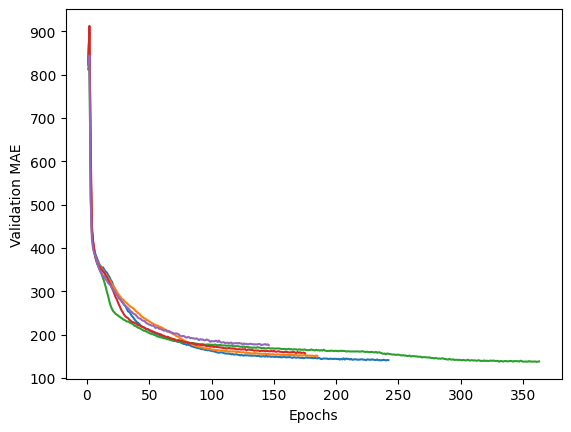

Hyperparameters: {'layer_nodes': [32, 16, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


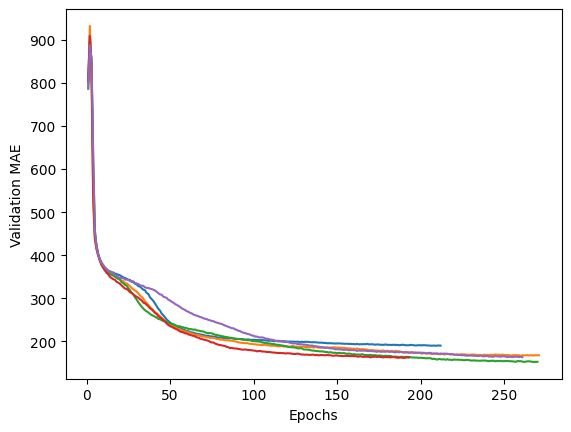

Hyperparameters: {'layer_nodes': [64, 32], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


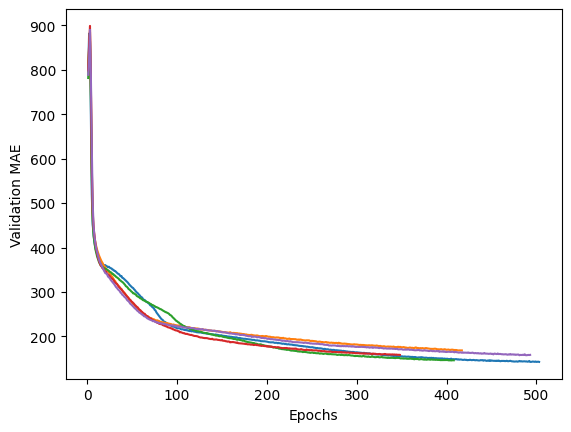

Hyperparameters: {'layer_nodes': [32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


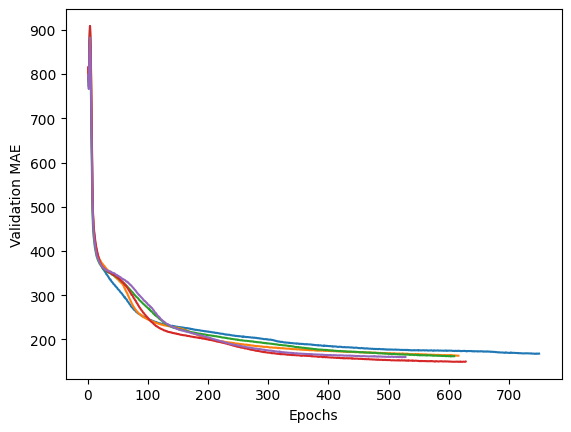

Hyperparameters: {'layer_nodes': [16, 8], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


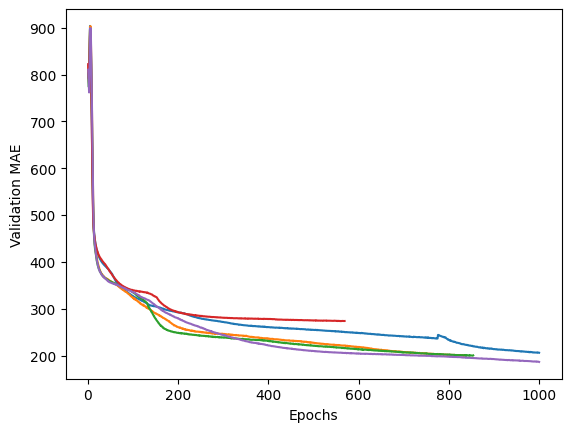

In [8]:
hyperaparameters_list = {
        "layer_nodes": [[64, 32, 16], [32, 16, 16], [64, 32], [32, 16], [16, 8]],
        "learning_rate": [0.001],
        "dropout": [0],
        "activation": ["relu"],
        "optimizer": [RMSprop]
    }

results_architecture = run_hyperparameters_k_fold(hyperaparameters_list, X_train, y_train)

In [9]:
results_architecture_df = pd.DataFrame(results_architecture)
results_architecture_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.427237,186111.196875
1,"[32, 16, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,169.710962,208546.715625
2,"[64, 32]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.305295,193158.209375
3,"[32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,165.270343,200889.571875
4,"[16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,217.740765,303064.471875


We can see that the largest layer architecture yields the best results. Therefore, we test out even larger architectures.

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


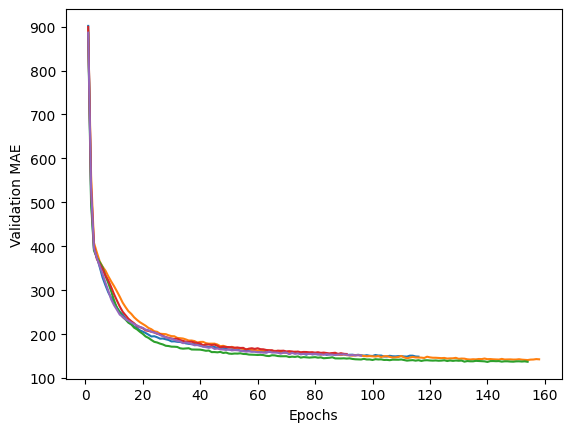

Hyperparameters: {'layer_nodes': [64, 32, 16, 8], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


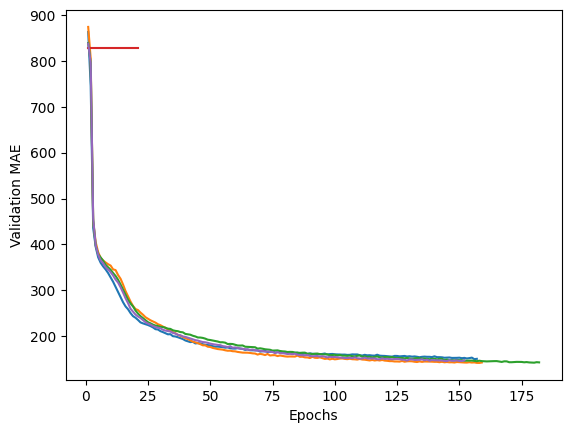

Hyperparameters: {'layer_nodes': [32, 16, 8], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


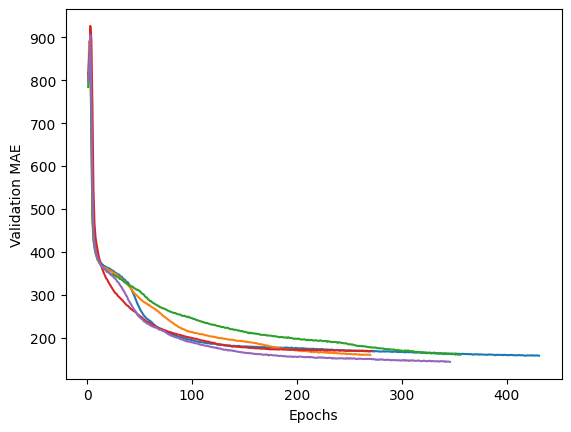

In [10]:
hyperaparameters_list = {
        "layer_nodes": [[64, 64, 32, 16], [64, 32, 16, 8], [32, 16, 8]],
        "learning_rate": [0.001],
        "dropout": [0],
        "activation": ["relu"],
        "optimizer": [RMSprop]
    }

results_architecture_2 = run_hyperparameters_k_fold(hyperaparameters_list, X_train, y_train)

In [11]:
results_architecture_df = pd.concat([results_architecture_df, pd.DataFrame(results_architecture_2)], axis=0)
results_architecture_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.427237,1.861112e+05
1,"[32, 16, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,169.710962,2.085467e+05
2,"[64, 32]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.305295,1.931582e+05
3,"[32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,165.270343,2.008896e+05
4,"[16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,217.740765,3.030645e+05
0,"[64, 64, 32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.118420,1.728949e+05
1,"[64, 32, 16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,275.760941,1.057474e+06
2,"[32, 16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,161.617307,2.000289e+05


We observe that the largest model with a 64-64-32-16 layer architecture has the best results. Now we want to test out different learning rates and dropout values to regularize the model.

### Learning Rate and Dropout

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.0001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


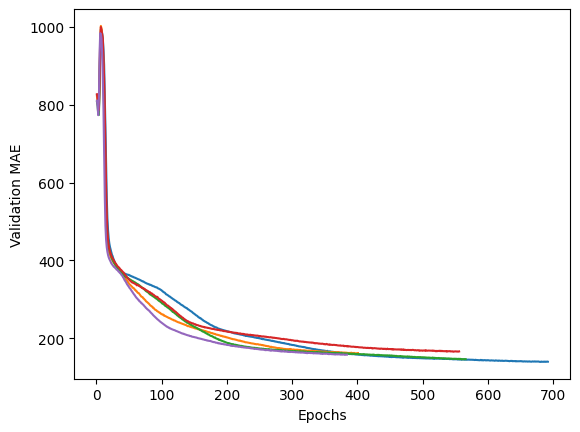

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.0001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


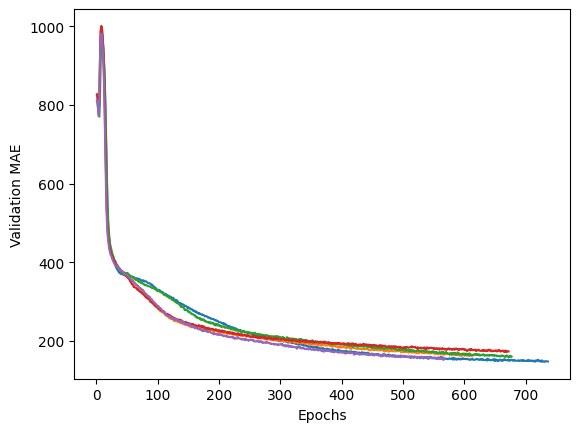

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.0001, 'dropout': 0.1, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


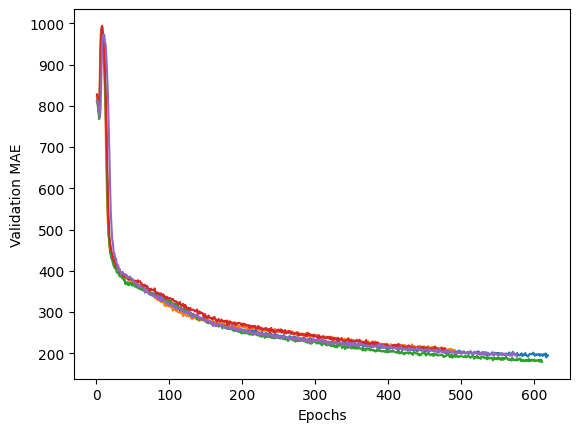

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


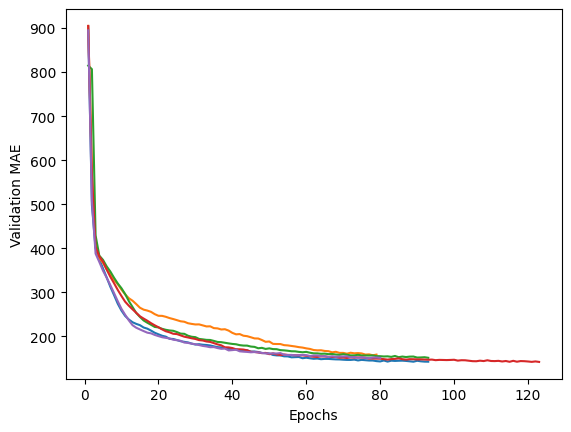

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


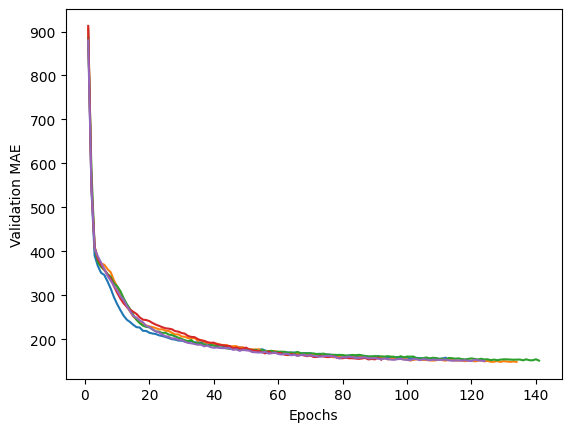

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.1, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


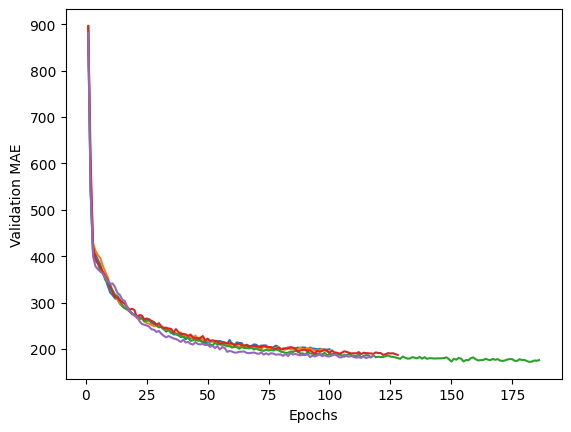

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


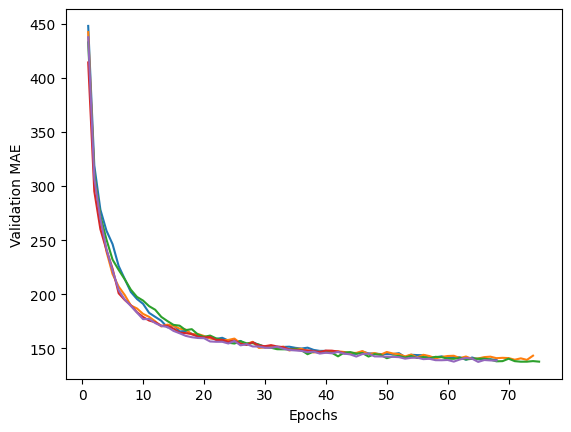

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


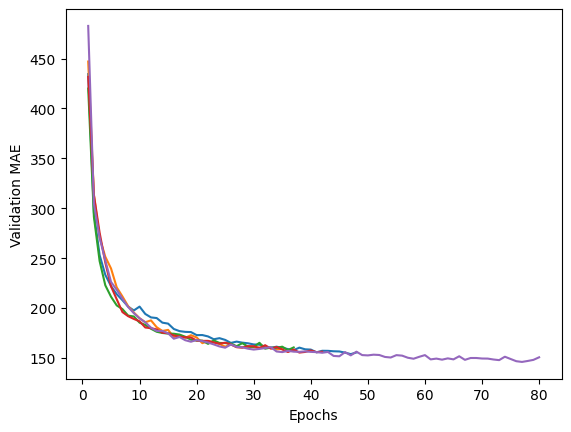

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0.1, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


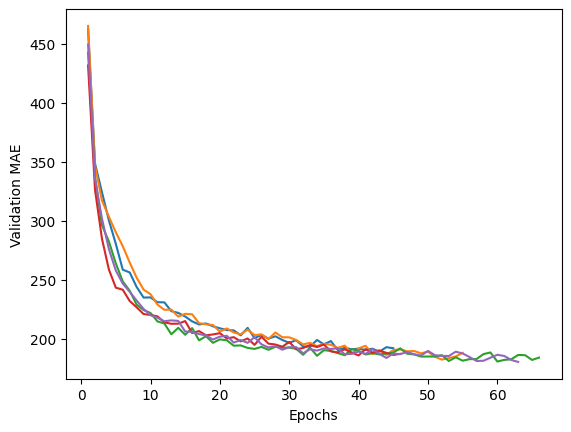

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.1, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


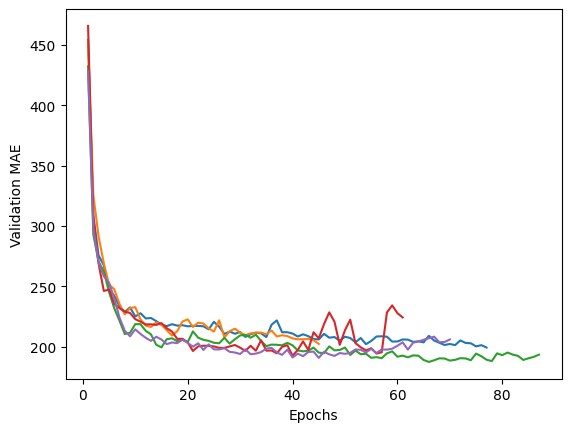

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.1, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


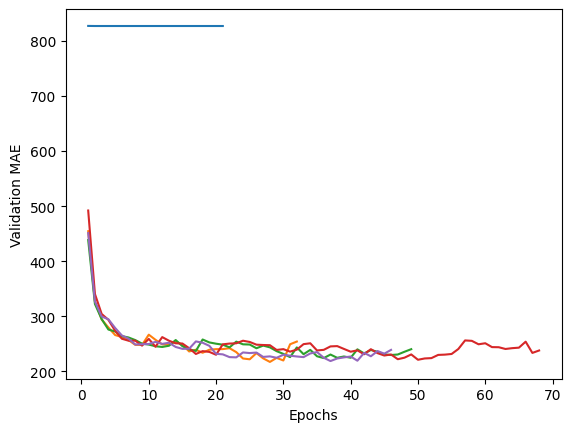

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.1, 'dropout': 0.1, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


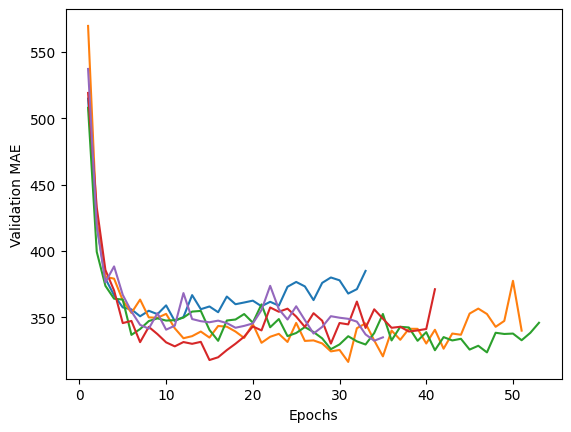

In [12]:
hyperaparameters_list = {
        "layer_nodes": [[64, 64, 32, 16]],
        "learning_rate": [0.0001, 0.001, 0.01, 0.1],
        "dropout": [0, 0.01, 0.1],
        "activation": ["relu"],
        "optimizer": [RMSprop]
    }

results_lr_do = run_hyperparameters_k_fold(hyperaparameters_list, X_train, y_train)

In [13]:
results_4_h6_df = pd.concat([results_architecture_df, pd.DataFrame(results_lr_do)], axis=0)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.427237,1.861112e+05
1,"[32, 16, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,169.710962,2.085467e+05
2,"[64, 32]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.305295,1.931582e+05
3,"[32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,165.270343,2.008896e+05
4,"[16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,217.740765,3.030645e+05
0,"[64, 64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.118420,1.728949e+05
1,"[64, 32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,275.760941,1.057474e+06
2,"[32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,161.617307,2.000289e+05
0,"[64, 64, 32, 16]",0.0001,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.684586,1.889000e+05
1,"[64, 64, 32, 16]",0.0001,0.01,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.287140,1.850200e+05


In this table we can see that the learning rate 0.01 and zero dropout reach the best MAE of 139.

### Activation

Now we test the activation function within the hidden layers, whether relu or sigmoid works better. For the output node we use Relu to eliminate negative values.

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


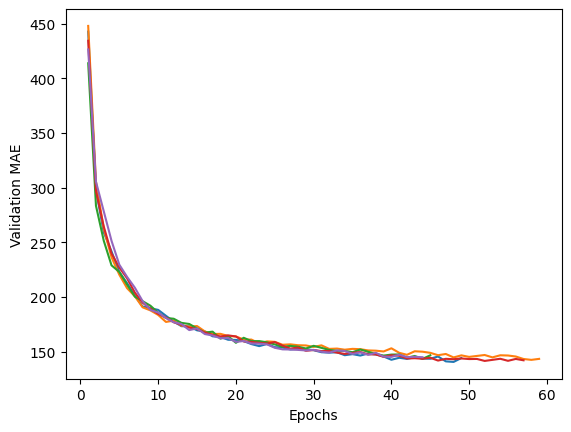

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


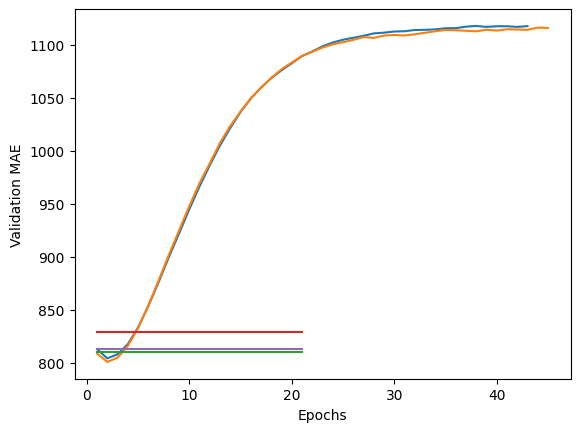

In [16]:
hyperaparameters_list = {
        'layer_nodes': [[64, 64, 32, 16]],
        'learning_rate': [0.01],
        'dropout': [0],
        'activation': ['relu', 'sigmoid'],
        'optimizer': [RMSprop]
    }

results_activation = run_hyperparameters_k_fold(hyperaparameters_list, X_train, y_train)

In [17]:
results_4_h6_df = pd.concat([results_4_h6_df, pd.DataFrame(results_activation)], axis=0)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.427237,1.861112e+05
1,"[32, 16, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,169.710962,2.085467e+05
2,"[64, 32]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.305295,1.931582e+05
3,"[32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,165.270343,2.008896e+05
4,"[16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,217.740765,3.030645e+05
0,"[64, 64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.118420,1.728949e+05
1,"[64, 32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,275.760941,1.057474e+06
2,"[32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,161.617307,2.000289e+05
0,"[64, 64, 32, 16]",0.0001,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.684586,1.889000e+05
1,"[64, 64, 32, 16]",0.0001,0.01,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.287140,1.850200e+05


Sigmoid performs way worse than relu so we keep relu as our activation function in the hidden layers.

### Batch Size

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, 'batch_size': 8}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


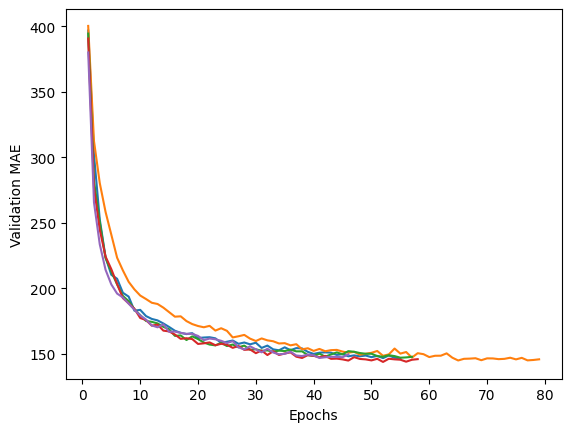

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, 'batch_size': 16}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


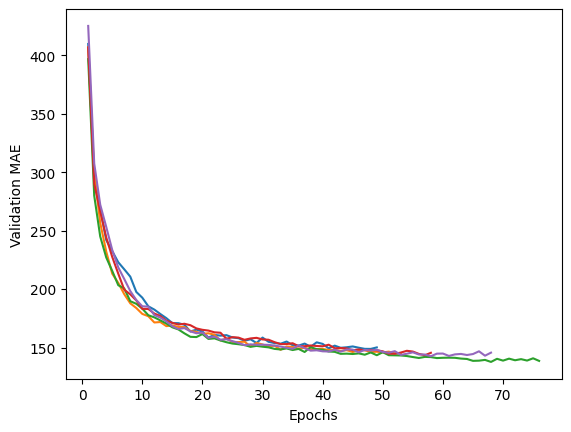

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, 'batch_size': 64}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


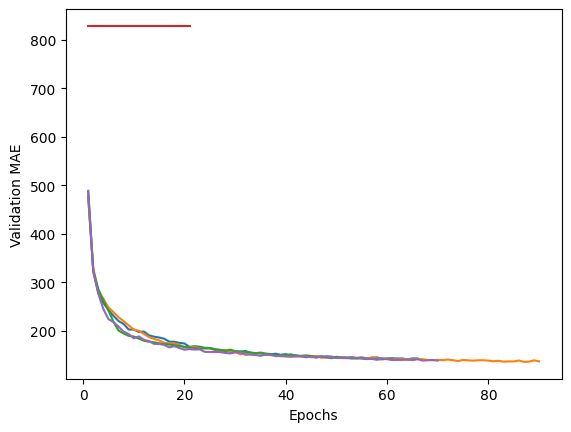

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, 'batch_size': 128}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


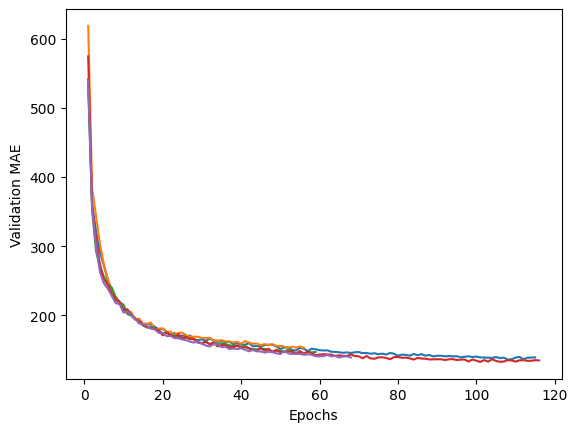

In [24]:
hyperaparameters_list = [{
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.01,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop,
        'batch_size': 8
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.01,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop,
        'batch_size': 16
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.01,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop,
        'batch_size': 64
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.01,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop,
        'batch_size': 128
    }]

results_bs = []
ep = 1000
k = 5


for hyperparameters in hyperaparameters_list:
    print("Hyperparameters: {}".format(hyperparameters))
    val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
        X_train, 
        y_train, 
        k=k, 
        epochs=ep, 
        batch_size=hyperparameters["batch_size"],
        verbose=0,
        hyperparams=hyperparameters)

    mae_mean = np.mean(val_mae)
    mse_mean = np.mean(val_mse)

    for i in range(k):
        plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()
    
    hyperparameters["epochs"] = ep
    hyperparameters["mae"] = mae_mean
    hyperparameters["mse"] = mse_mean
    results_bs.append(hyperparameters)

In [32]:
results_4_h6_df = pd.concat([results_4_h6_df, pd.DataFrame(results_bs)], axis=0)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.427237,1.861112e+05
1,"[32, 16, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,169.710962,2.085467e+05
2,"[64, 32]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.305295,1.931582e+05
3,"[32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,165.270343,2.008896e+05
4,"[16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,217.740765,3.030645e+05
0,"[64, 64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.118420,1.728949e+05
1,"[64, 32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,275.760941,1.057474e+06
2,"[32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,161.617307,2.000289e+05
0,"[64, 64, 32, 16]",0.0001,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.684586,1.889000e+05
1,"[64, 64, 32, 16]",0.0001,0.01,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.287140,1.850200e+05


The batch size 128 has the best MAE of 137.81 .

In [33]:
results_4_h6_df.to_csv("../../data/predictive/NN_results_4_h3_06.csv", index=False)

As we can see, the optimized hyperparameters are a layer architecture of [64,64,32,16], a learning rate of 0.01, no dropout, the relu activation function in hidden layers and a batch size of 128. This model needed less than 120 epochs for the five folds. Therefore, an epoch value of 120 seems reasonable.

## All Time and Location resolutions

In [19]:
hyperaparameters = {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.01,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    }

In [20]:
results_all = []

for time_bucket_length in [1, 2, 4, 6, 24]:
    for location_bucket in ["h3_05", "h3_06", "h3_07", "h3_08", "h3_09", "centroid"]:

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)
        
        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

        model = build_model(
            X_train,
            layer_nodes=hyperaparameters["layer_nodes"],
            learning_rate=hyperaparameters["learning_rate"],
            dropout=hyperaparameters["dropout"],
            activation=hyperaparameters["activation"],
            optimizer=hyperaparameters["optimizer"])
        
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=20, 
            min_delta=y_train.std()*0.1, 
            restore_best_weights=True)

        model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=1000,
            batch_size=128,
            verbose=0,
            callbacks=[early_stop]
            )

        # evaluate metrics
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
        mse = mean_squared_error(y_test, y_pred).round(2)
        r2 = r2_score(y_test, y_pred).round(4)

        # save best params and metrics
        results_all.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "r2": r2
        })
        
        print()

Time bucket length: 1h
Location bucket: h3_05
(48690, 13)
(48690, 20)
305/305 [==============================] - 0s 454us/step

Time bucket length: 1h
Location bucket: h3_06
(68295, 13)
(68295, 36)
427/427 [==============================] - 0s 457us/step

Time bucket length: 1h
Location bucket: h3_07
(163126, 13)
(163126, 102)
1020/1020 [==============================] - 0s 412us/step

Time bucket length: 1h
Location bucket: h3_08
(410177, 13)
(410177, 310)
2564/2564 [==============================] - 1s 454us/step

Time bucket length: 1h
Location bucket: h3_09
(571788, 13)
(571788, 449)
3574/3574 [==============================] - 2s 466us/step

Time bucket length: 1h
Location bucket: centroid
(584995, 8)
(584995, 449)
3657/3657 [==============================] - 2s 472us/step

Time bucket length: 2h
Location bucket: h3_05
(25264, 13)
(25264, 20)
158/158 [==============================] - 0s 433us/step

Time bucket length: 2h
Location bucket: h3_06
(37357, 13)
(37357, 36)
234/234 [===

In [21]:
results_all_df = pd.DataFrame(results_all)
results_all_df

,time_bucket_length,location_bucket,mae,mape,mse,r2
0,1,h3_05,60.44,0.82,27251.86,0.9521
1,1,h3_06,43.77,0.89,14294.59,0.9529
2,1,h3_07,20.69,0.97,2749.22,0.9594
3,1,h3_08,10.03,0.77,534.61,0.9297
4,1,h3_09,7.56,0.72,299.91,0.9309
5,1,centroid,7.63,0.90,285.93,0.9278
6,2,h3_05,110.58,0.81,95995.40,0.9570
7,2,h3_06,78.75,0.95,52505.07,0.9555
8,2,h3_07,36.56,0.94,11862.01,0.9515
9,2,h3_08,15.94,1.01,1620.50,0.9378


In [22]:
results_all_df.to_csv("../../data/predictive/NN_results_all.csv", index=False)

<Axes: xlabel='time_bucket_length', ylabel='mape'>

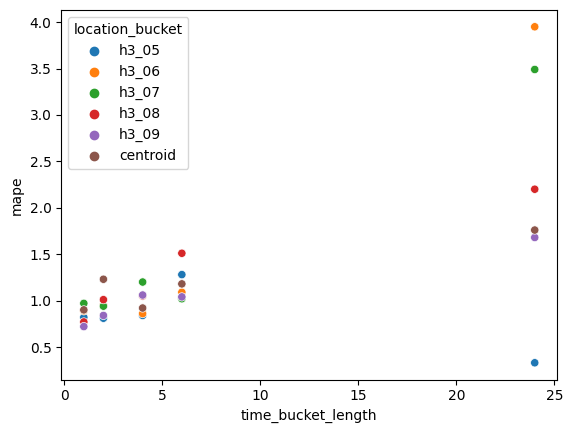

In [23]:
sns.scatterplot(x="time_bucket_length", y="mape", hue="location_bucket", data=results_all_df)

Because we think that predicting taxi demand on a daily basis is not specific enough because there are fluctuations in the taxidemand over the day, we plot the MAPE values for the time bucktes up until 6.

<Axes: xlabel='time_bucket_length', ylabel='mape'>

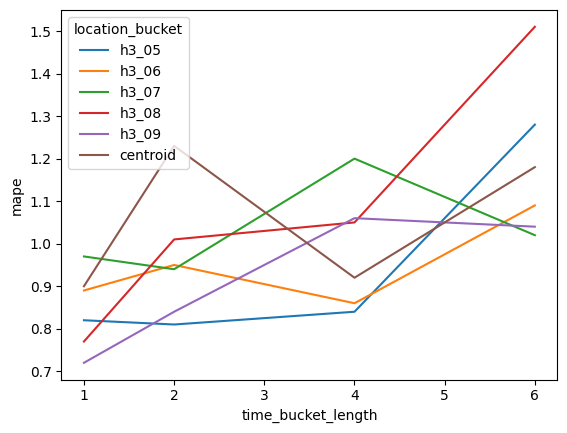

In [24]:
sns.lineplot(x="time_bucket_length", y="mape", hue="location_bucket", data=results_all_df[(results_all_df["time_bucket_length"] < 24)])

We can see that the mean percentage error varies between the different time and location resolutions. The resolutions chosen for the SVM model (h3 resolution 8 and time resolution 4h) here has a mean percentage error of 1.05 but a lower mean absolute error than the neural network. For all neural network models the r2 score is higher (all over 0.9) than for the SVM models. 